In [37]:
import json
import requests
import csv
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Step 1: Gathering the data



Referenced API code from this [link](https://public.paws.wmcloud.org/User:Jtmorgan/data512_a1_example.ipynb) which is under CC0 license.

We will use the following APIs
- Pagecounts API ([API documentation](https://wikimedia.org/api/rest_v1/#/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end) )
- The Pageviews API ([API documentation](https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)

## API calls

Here, we will define API endpoints for both PageCount API (legacy) and PageViews API.

Next, we define headers for the API to include my own information

In [11]:
headers = {
    'User-Agent': 'https://github.com/mightydeveloper',
    'From': 'tonykim7@uw.edu'
}

Next, we will define functions to make API calls more easily.

### Define PageCount API call, parameterized by `access_type`

Note that this is the legacy API

In [15]:
def pagecount_api_call(access_type):
    endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
    parameters = {
        "project" : "en.wikipedia.org",
        "access-site" : access_type,
        "granularity" : "monthly",
        "start" : "2008010100",
        # for end use 1st day of month following final month of data
        "end" : "2020090100"
    }
    call = requests.get(endpoint_legacy.format(**parameters), headers=headers)
    response = call.json()
    
    return response

### Define PageViews API call, parameterized by `access_type`

In [18]:
def pageviews_api_call(access_type):
    endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
    parameters = {
        "project" : "en.wikipedia.org",
        "access" : access_type,
        "agent" : "user", # This will give only organic (user) traffic, as opposed to traffic by web crawlers or spiders
        "granularity" : "monthly",
        "start" : "2014100100",
        # for end use 1st day of month following final month of data
        "end" : '2020090100'
    }
    call = requests.get(endpoint_pageviews.format(**parameters), headers=headers)
    response = call.json()
    
    return response

## Make API calls and save results

### Make API call to PageCounts endpoint and save the result

This will make 2 API calls to gather `access_type` of `desktop-site` and `mobile_site`


In [16]:
api_name = 'pagecounts'
first_month = '200801'
last_month = '202008'
for access_type in ['desktop-site', 'mobile-site']:
    json_obj = pagecount_api_call(access_type)
    filename = f'{api_name}_{access_type}_{first_month}-{last_month}.json'
    with open(filename, 'w') as f:
        json.dump(json_obj, f)

### Make API call to PageViews endpoint and save the result
This will make 3 API calls to gather `access_type` of `desktop`, `mobile-app`, and `mobile-web`

In [19]:
api_name = 'pageviews'
first_month = '201410'
last_month = '202008'
for access_type in ['desktop', 'mobile-app', 'mobile-web']:
    json_obj = pageviews_api_call(access_type)
    filename = f'{api_name}_{access_type}_{first_month}-{last_month}.json'
    with open(filename, 'w') as f:
        json.dump(json_obj, f)

# Step 2: Processing the data

## Read the data

In [20]:
with open('pagecounts_desktop-site_200801-202008.json') as f:
    pc_desktop = json.load(f)
with open('pagecounts_mobile-site_200801-202008.json') as f:
    pc_mobile = json.load(f)
with open('pageviews_desktop_201410-202008.json') as f:
    pv_desktop = json.load(f)
with open('pageviews_mobile-app_201410-202008.json') as f:
    pv_mobile_app = json.load(f)
with open('pageviews_mobile-web_201410-202008.json') as f:
    pv_mobile_web = json.load(f)

### Parse PageCounts Result

In [26]:
pc = defaultdict(Counter)
for obj in pc_desktop['items']:
    ts = obj['timestamp'][:6]
    pc[ts]['desktop'] += obj['count']
for obj in pc_mobile['items']:
    ts = obj['timestamp'][:6]
    pc[ts]['mobile'] += obj['count']

### Parse PageViews Result

In [30]:
pv = defaultdict(Counter)
for obj in pv_desktop['items']:
    ts = obj['timestamp'][:6]
    pv[ts]['desktop'] += obj['views']
for obj in pv_mobile_app['items']:
    ts = obj['timestamp'][:6]
    pv[ts]['mobile'] += obj['views']
for obj in pv_mobile_web['items']:
    ts = obj['timestamp'][:6]
    pv[ts]['mobile'] += obj['views']

## Write result to csv file

In [39]:
# Figure out keys for pretty ordering in csv
months = set(pc.keys()) | set(pv.keys())
months = sorted(months)

with open('en-wikipedia_traffic_200801-202008.csv', 'w', newline='') as csvfile:
    fieldnames = ['year', 'month', 
                  'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 
                  'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for ts in months:
        dic = dict()
        dic['year'] = int(ts[:4])
        dic['month'] = int(ts[4:])

        dic['pagecount_all_views'] = pc[ts]['desktop'] + pc[ts]['mobile']
        dic['pagecount_desktop_views'] = pc[ts]['desktop']
        dic['pagecount_mobile_views'] = pc[ts]['mobile']

        dic['pageview_all_views'] = pv[ts]['desktop'] + pv[ts]['mobile']
        dic['pageview_desktop_views'] = pv[ts]['desktop']
        dic['pageview_mobile_views'] = pv[ts]['mobile']

        writer.writerow(dic)

# Step 3: Analyze and generate graph

## Read data

In [40]:
import pandas as pd
df = pd.read_csv('en-wikipedia_traffic_200801-202008.csv')

## Draw graph

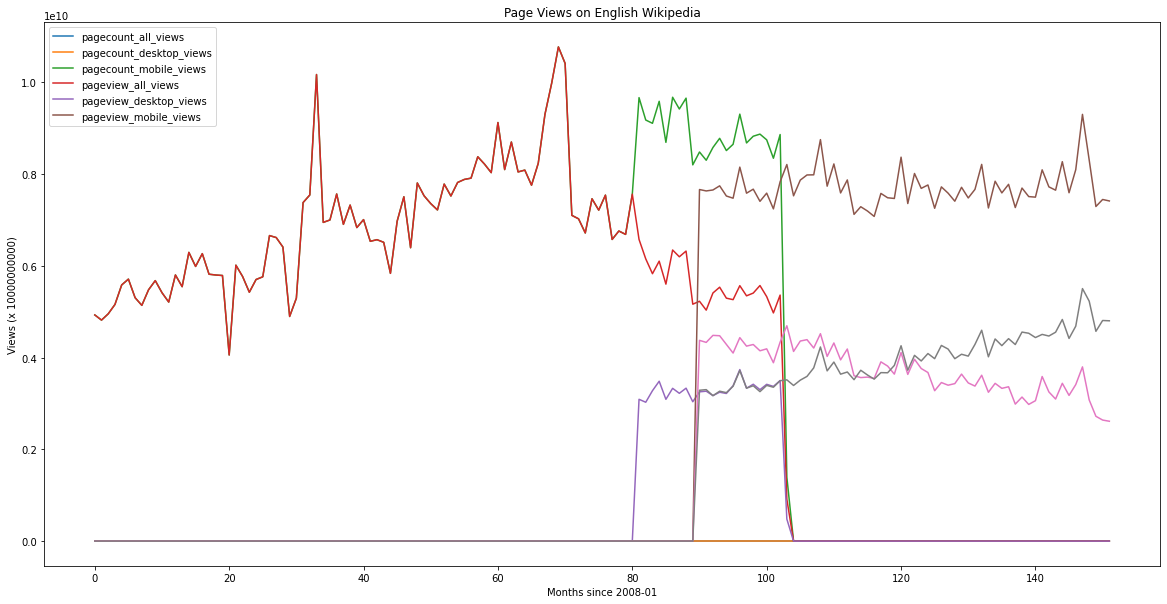

In [60]:
plt.figure(figsize=(20,10))
plt.plot(df)
plt.title('Page Views on English Wikipedia')
plt.ylabel('Views (x 10000000000)')
plt.xlabel('Months since 2008-01')
plt.legend(['pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 
                  'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views'])
plt.savefig('plot.jpg')
plt.show()
